In [188]:
import treescope
import torch
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataset
from src.configs import ModelArgs
from torch_geometric.loader import DataLoader
from loguru import logger
from dataclasses import asdict
import linear_operator_learning as lol
import matplotlib.pyplot as plt
import numpy as np
import pickle


treescope.basic_interactive_setup()

In [189]:
# Write new configs on wandb.
import wandb

api = wandb.Api()

for run in api.runs("csml/encoderops_chignolin"):
    updated: bool = False
    if run.state == "finished":
        model_args = asdict(eval(run.config['model_args']))
        for k, v in model_args.items():
            if k not in run.config:
                run.config[k] = v
                updated = True
        run.update()
        if updated:
            logger.info(f"Updated run {run.id}")
        else:
            logger.info(f"Run {run.id} was already up to date")

2025-04-16 11:28:36.829 | INFO     | __main__:<module>:18 - Run liq5y008 was already up to date
2025-04-16 11:28:37.237 | INFO     | __main__:<module>:18 - Run fmxldw5g was already up to date
2025-04-16 11:28:37.621 | INFO     | __main__:<module>:18 - Run 6gm38ox1 was already up to date
2025-04-16 11:28:38.008 | INFO     | __main__:<module>:18 - Run 5kigk9xx was already up to date
2025-04-16 11:28:38.425 | INFO     | __main__:<module>:18 - Run b8qyu8rs was already up to date
2025-04-16 11:28:38.867 | INFO     | __main__:<module>:18 - Run nu8v1mpx was already up to date
2025-04-16 11:28:39.242 | INFO     | __main__:<module>:18 - Run 73dtj1jp was already up to date
2025-04-16 11:28:39.669 | INFO     | __main__:<module>:18 - Run p52qnu9d was already up to date
2025-04-16 11:28:40.048 | INFO     | __main__:<module>:18 - Run b1du1e7n was already up to date
2025-04-16 11:28:40.677 | INFO     | __main__:<module>:18 - Run 49x4nrkj was already up to date
2025-04-16 11:28:41.167 | INFO     | __m

In [ ]:
reg = 1e-4
if Path("results.pkl").exists():
    results = pickle.load(open("results.pkl", "rb"))
else:
    results = {}
    for run in api.runs("csml/encoderops_chignolin"):
        if run.state == "finished":
            logger.info(f"Run {run.id}")
            data_path = Path(f"/home/novelli/encoderops/encoderops_chignolin/{run.id}")
            epoch = 249
            model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
            dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)
            embeddings = {"t": [], "lag": []}
            model = model.eval()

            dataloader = DataLoader(
                dataset, batch_size=128, shuffle=False
            )
            with torch.no_grad():
                for batch in dataloader:
                    for k, v in batch.items():
                        batch[k] = v.to(model.device)
                    # data
                    x_t = model._setup_graph_data(batch)
                    x_lag = model._setup_graph_data(batch, key="item_lag")
                    # forward
                    f_t = model.forward_nn(x_t)
                    f_lag = model.forward_nn(x_lag)
                    embeddings["t"].append((f_t.detach().cpu()))
                    embeddings["lag"].append((f_lag.detach().cpu()))
            phi_t = torch.cat(embeddings["t"])
            phi_lag = torch.cat(embeddings["lag"])
            cov_X = lol.nn.stats.covariance(phi_t)
            cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
            cov_Y = lol.nn.stats.covariance(phi_lag)
            cov_XY = lol.nn.stats.covariance(phi_t, phi_lag)
            G = torch.linalg.solve(cov_X, cov_XY)
            l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
            r_fun = phi_t.to(Q.dtype) @ Q 
            results[run.id] = {
                "embedding_t": phi_t,
                "embedding_lag": phi_lag,
                "eigenvalues": l,
                "eigenvectors": Q,
                "r_fun": r_fun
            }
            pickle.dump(results, open("results.pkl", "wb"))

In [191]:
def implied_timescale(ev, lagtime_ns: float = 5.0):
    if torch.is_tensor(ev):
        ev = ev.numpy(force=True)
    return np.sort((1/-np.log(np.abs(ev)))*lagtime_ns)[::-1]

In [215]:
model.model_args

ModelArgs(latent_dim=64, linear_lora=16, encoder_lr=0.01, linear_lr=0.01, epochs=250, max_grad_norm=None, normalize_lin=False, regularization=0.01, min_encoder_lr=0.0001, simnorm_dim=4, n_bases=16, n_layers=3, n_filters=32, n_hidden_channels=64)

(2.0, 100.0)

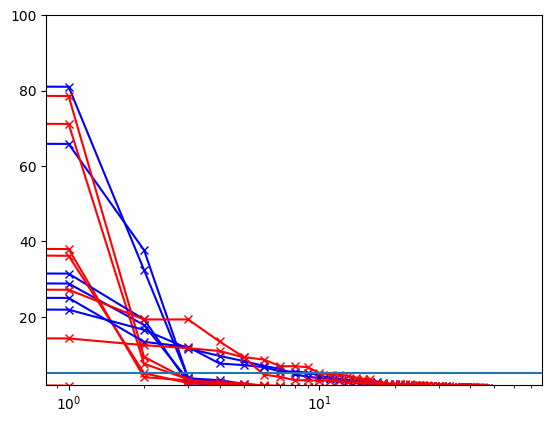

In [222]:
for run_id, values in results.items():
    data_path = Path(f"/home/novelli/encoderops/encoderops_chignolin/{run_id}")
    epoch = 249
    model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    
    color = 'b' if model.model_args.normalize_lin else 'r'
    color = 'b' if model.model_args.max_grad_norm is None else 'r'
    color = 'b' if model.model_args.regularization == 0.0001 else 'r'
    ts = implied_timescale(values['eigenvalues'])
    plt.plot(ts, 'x-', label=run_id, color= color)
#plt.yscale('log')
plt.xscale('log')
plt.axhline(5)
plt.ylim(2, 100)

In [165]:
run_id = "sfv6m0f6"
data_path = Path(f"/home/novelli/encoderops/encoderops_chignolin/{run_id}")
epoch = 249
model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))

In [166]:
dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)

In [ ]:
from tqdm import tqdm


embeddings = {"t": [], "lag": []}
model = model.eval()

dataloader = DataLoader(
    dataset, batch_size=128, shuffle=False
)
with torch.no_grad():
    for batch in tqdm(dataloader):
        for k, v in batch.items():
            batch[k] = v.to(model.device)
        # data
        x_t = model._setup_graph_data(batch)
        x_lag = model._setup_graph_data(batch, key="item_lag")
        # forward
        f_t = model.forward_nn(x_t)
        f_lag = model.forward_nn(x_lag)
        embeddings["t"].append((f_t.detach().cpu()))
        embeddings["lag"].append((f_lag.detach().cpu()))

100%|██████████| 168/168 [00:58<00:00,  2.89it/s]


In [179]:
reg = 1e-3
cov_X = lol.nn.stats.covariance(phi_t)
fit_result = lol.nn.ridge_least_squares(cov_X, tikhonov_reg=reg)
cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
cov_Y = lol.nn.stats.covariance(phi_lag)
cov_XY = lol.nn.stats.covariance(phi_t, phi_lag)

eig_decomp = lol.nn.eig(fit_result, cov_XY)
G = torch.linalg.solve(cov_X, cov_XY)
logger.info("Computed estimator")
l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
logger.info("Computed eig decomposition")

2025-04-16 11:06:27.128 | INFO     | __main__:<module>:10 - Computed estimator


2025-04-16 11:06:27.131 | INFO     | __main__:<module>:12 - Computed eig decomposition


In [180]:
G_e2e =   (model.linear[0].weight.T.detach().cpu()@model.linear[1].weight.T.detach().cpu() ) @ cov_Y

(-1.0994713695023444,
 1.0999748271191592,
 -1.0998615404412626,
 1.0998615404412626)

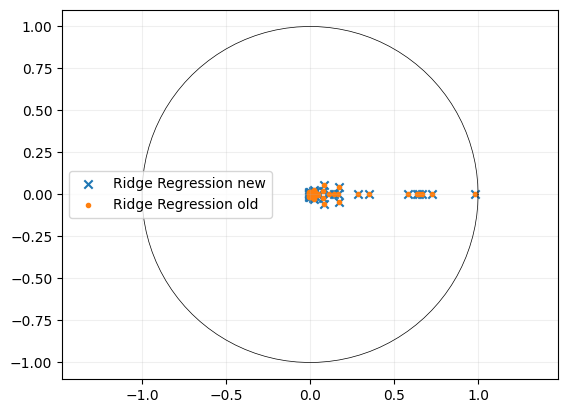

In [181]:
import matplotlib.pyplot as plt
import numpy as np
N = phi_t.shape[0]
plt.scatter(l.real, l.imag, marker='x', label="Ridge Regression new")
plt.scatter(eig_decomp['values'].real, eig_decomp['values'].imag, marker='.', label="Ridge Regression old")
#plt.scatter(e1.real, e1.imag, label="end2end")
plt.grid(alpha=0.2)
plt.legend()
# Draw unit circle
t = np.linspace(0, 2 * np.pi, 100)
r = 1
x = r * np.cos(t)
y = r * np.sin(t)
plt.plot(x, y, color='k', lw=0.5)
plt.axis('equal')

In [182]:
r_fun = phi_t.to(Q.dtype) @ Q 
l_fun = (torch.linalg.solve(Q, phi_t.to(Q.dtype).T)).T
l

tensor([ 9.7893e-01+0.0000e+00j,  7.2314e-01+0.0000e+00j,
         5.8485e-01+0.0000e+00j,  6.6638e-01+0.0000e+00j,
         6.4927e-01+0.0000e+00j,  6.3806e-01+0.0000e+00j,
         3.5250e-01+0.0000e+00j,  2.8303e-01+0.0000e+00j,
         1.7001e-01+4.1889e-02j,  1.7001e-01-4.1889e-02j,
         1.6861e-01+0.0000e+00j,  1.4543e-01+0.0000e+00j,
         8.2480e-02+5.9284e-02j,  8.2480e-02-5.9284e-02j,
         1.1220e-01+0.0000e+00j,  7.6250e-02+2.3273e-02j,
         7.6250e-02-2.3273e-02j,  4.4563e-02+5.5941e-03j,
         4.4563e-02-5.5941e-03j,  2.5924e-02+2.8465e-02j,
         2.5924e-02-2.8465e-02j,  2.9472e-02+1.1993e-02j,
         2.9472e-02-1.1993e-02j,  1.5729e-02+1.8913e-02j,
         1.5729e-02-1.8913e-02j,  2.6220e-02+0.0000e+00j,
        -4.5816e-03+1.6603e-02j, -4.5816e-03-1.6603e-02j,
         1.8193e-02+7.5042e-03j,  1.8193e-02-7.5042e-03j,
         4.2861e-04+1.4748e-02j,  4.2861e-04-1.4748e-02j,
        -8.9323e-03+0.0000e+00j,  1.2740e-02+2.9004e-03j,
         1.2740e-02-2.9004e-03j, -5.2023e-03+6.1131e-03j,
        -5.2023e-03-6.1131e-03j, -3.1400e-03+7.4208e-03j,
        -3.1400e-03-7.4208e-03j, -4.6061e-03+0.0000e+00j,
         5.5961e-03+4.6934e-03j,  5.5961e-03-4.6934e-03j,
         2.7599e-03+5.3117e-03j,  2.7599e-03-5.3117e-03j,
        -2.7144e-03+0.0000e+00j,  4.8342e-03+0.0000e+00j,
         2.9852e-03+0.0000e+00j,  8.2368e-04+0.0000e+00j,
        -1.9483e-06+5.0085e-06j, -1.9483e-06-5.0085e-06j,
         1.6932e-06+3.7631e-06j,  1.6932e-06-3.7631e-06j,
        -4.0173e-06+1.1632e-06j, -4.0173e-06-1.1632e-06j,
        -2.6875e-06+9.5456e-07j, -2.6875e-06-9.5456e-07j,
        -1.5285e-06+1.2633e-06j, -1.5285e-06-1.2633e-06j,
         1.3092e-06+1.9489e-06j,  1.3092e-06-1.9489e-06j,
         1.5435e-06+9.2117e-07j,  1.5435e-06-9.2117e-07j,
         1.7343e-06+0.0000e+00j,  4.9803e-07+0.0000e+00j])

In [183]:
from mlcolvar.utils.fes import compute_fes

[<matplotlib.lines.Line2D at 0x7f062f6d5590>]

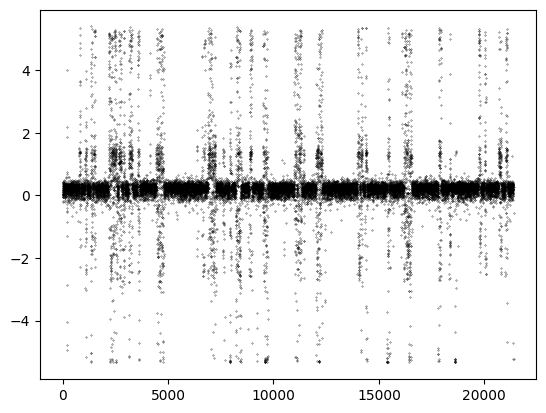

In [185]:
plt.plot(l_fun[:, 1].real, '.', color='k', markersize = 0.5)

Text(0.5, 0, 'Deep-TICA 2')

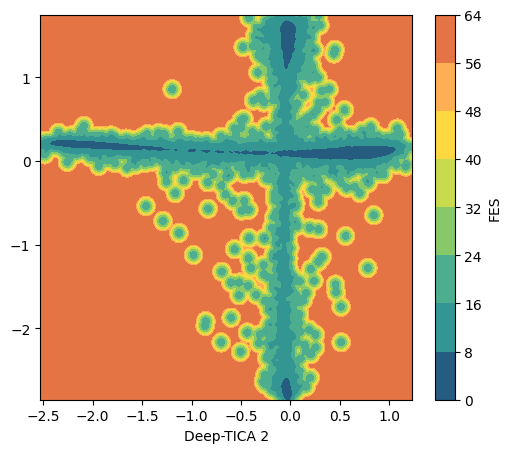

In [154]:
s = torch.stack([e_fun[:, 1].real, e_fun[:, 2].real])
fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)
fes,grid,bounds,error = compute_fes(s.T,
    blocks=1,
    num_samples=1000,
    bandwidth=0.005, scale_by='range',
    plot=True, ax = ax, eps=1e-8)

ax.set_xlabel('Deep-TICA 1')
ax.set_xlabel('Deep-TICA 2')